# Visual Wake Words (VWW) Project - Phase 4: Simulation & Final Report
**Goal:** Simulate the "Edge" inference process using Python, measure latency, and generate the final project report artifacts.
**Environment:** Google Colab / TensorFlow 2.x

## 1. Setup & Load Quantized Model
We load the Int8 quantized model generated in Phase 3.

In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import pathlib
import os

# Define paths
tflite_model_path = 'vww_v2_int8.tflite'
dataset_dir = pathlib.Path("vww_dataset")

if not os.path.exists(tflite_model_path):
    raise FileNotFoundError("Int8 TFLite model not found! Please run Phase 3 first.")

# Load Interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ Int8 Model Loaded.")
print(f"Input Shape: {input_details[0]['shape']}")
print(f"Input Type: {input_details[0]['dtype']}")

✅ Int8 Model Loaded.
Input Shape: [ 1 96 96  3]
Input Type: <class 'numpy.int8'>


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## 2. Latency Simulation
While we cannot measure exact MCU cycles in Python, we can measure the inference time on the Colab CPU. This gives us a relative baseline.
*   **Note:** Real MCU inference will be slower (e.g., 100ms - 500ms depending on clock speed).

In [2]:
# Generate random input for latency test
input_shape = input_details[0]['shape']
dummy_input = np.random.randint(-128, 127, input_shape, dtype=np.int8)

# Warmup
for _ in range(10):
    interpreter.set_tensor(input_details[0]['index'], dummy_input)
    interpreter.invoke()

# Measure Latency
num_runs = 100
start_time = time.time()

for _ in range(num_runs):
    interpreter.set_tensor(input_details[0]['index'], dummy_input)
    interpreter.invoke()

end_time = time.time()
avg_latency_ms = ((end_time - start_time) / num_runs) * 1000

print(f"Average Inference Latency (Colab CPU): {avg_latency_ms:.2f} ms")
print(f"Estimated FPS: {1000 / avg_latency_ms:.2f}")

Average Inference Latency (Colab CPU): 0.87 ms
Estimated FPS: 1150.13


## 3. Visual Inference Test
Let's pick a few random images from the validation set, run the Int8 model, and visualize the results. This is great for the final report.

Found 741 files belonging to 2 classes.


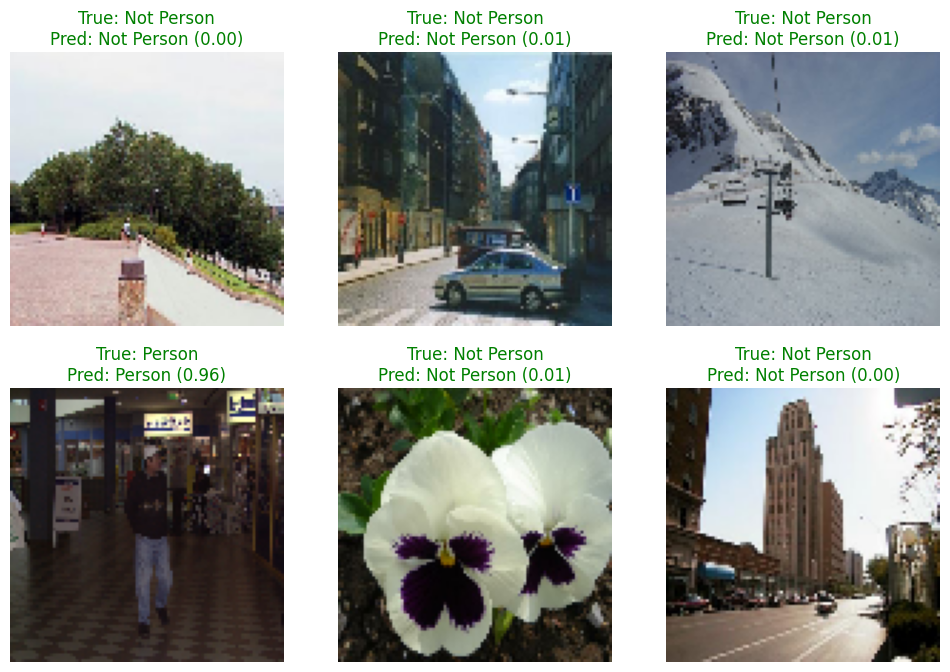

In [3]:
IMG_SIZE = 96
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir / 'validation',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    shuffle=True
)

def preprocess_int8(image):
    # Resize & Normalize to [-1, 1]
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image / 127.5) - 1.0
    
    # Quantize to Int8
    scale, zero_point = input_details[0]['quantization']
    image_q = (image / scale) + zero_point
    image_q = np.clip(image_q, -128, 127).astype(np.int8)
    return np.expand_dims(image_q, axis=0)

plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(val_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    
    # Run Inference
    input_data = preprocess_int8(image[0])
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Dequantize Output
    out_scale, out_zero_point = output_details[0]['quantization']
    prob = (output_data[0][0].astype(np.float32) - out_zero_point) * out_scale
    
    pred_label = "Person" if prob > 0.5 else "Not Person"
    true_label = "Person" if label.numpy()[0] == 1 else "Not Person"
    color = 'green' if pred_label == true_label else 'red'
    
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {pred_label} ({prob:.2f})", color=color)
    plt.axis("off")

plt.show()

## 4. Confusion Matrix
A professional metric to evaluate the model's performance on the entire validation set.

Running full validation for Confusion Matrix...


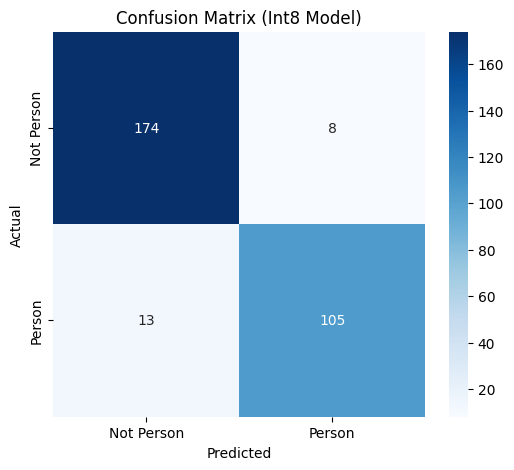

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

print("Running full validation for Confusion Matrix...")
for image, label in val_ds.take(300): # Take 300 samples or full dataset
    y_true.append(label.numpy()[0])
    
    input_data = preprocess_int8(image[0])
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    out_scale, out_zero_point = output_details[0]['quantization']
    prob = (output_data[0][0].astype(np.float32) - out_zero_point) * out_scale
    y_pred.append(1 if prob > 0.5 else 0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Person', 'Person'], yticklabels=['Not Person', 'Person'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Int8 Model)')
plt.show()